In [68]:
import scipy.io
import matplotlib.pyplot as plt
from skimage import feature, io, color
import numpy as np
import pandas as pd
import cv2
from tqdm import tqdm
from sklearn.metrics import pairwise_distances
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.model_selection import train_test_split

# 1 Dataset

In [2]:
def load_svhn_dataset(train_path, test_path):
    train_data = scipy.io.loadmat(train_path)
    test_data = scipy.io.loadmat(test_path)

    train_images = train_data['X']
    train_labels = train_data['y']
    test_images = test_data['X']
    test_labels = test_data['y']

    train_images = np.transpose(train_images, (3, 0, 1, 2))
    test_images = np.transpose(test_images, (3, 0, 1, 2))

    return train_images, train_labels, test_images, test_labels

In [3]:
# Provide the paths to SVHN train and test datasets
train_path = '/Users/louis.skowronek/PycharmProjects/pattern_recognition/term-project/train_32x32.mat'
test_path = '/Users/louis.skowronek/PycharmProjects/pattern_recognition/term-project/test_32x32.mat'

train_images, train_labels, test_images, test_labels = load_svhn_dataset(train_path, test_path)

In [4]:
# print shapes
print("Train images shape:", train_images.shape)
print("Train labels shape:", train_labels.shape)
print("Test images shape:", test_images.shape)
print("Test labels shape:", test_labels.shape)

Train images shape: (73257, 32, 32, 3)
Train labels shape: (73257, 1)
Test images shape: (26032, 32, 32, 3)
Test labels shape: (26032, 1)


In [63]:
# check class distribution
def visualize_class_distr(labels):
    # plot histogram
    counts, bins, _ = plt.hist(labels, bins=10, edgecolor='black')
    for i, (count, x) in enumerate(zip(counts, bins)):
        plt.text(x + 0.5, count, str(int(count)), ha='center', va='bottom')
        plt.text(x + 0.5, count / 2, str(int(i)), ha='center', va='center')

    # Set the x-axis ticks
    #plt.xticks(np.arange(1,10))

    # Add labels and a title
    plt.xlabel('Class')
    plt.ylabel('# number')
    plt.title('Class Distribution')

    # Show the plot
    plt.show()

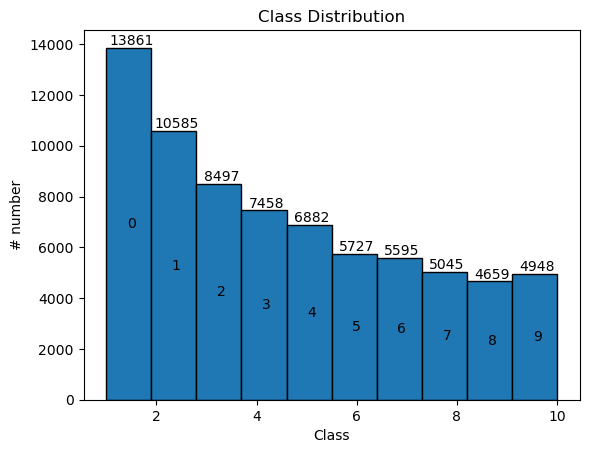

In [65]:
visualize_class_distr(train_labels)

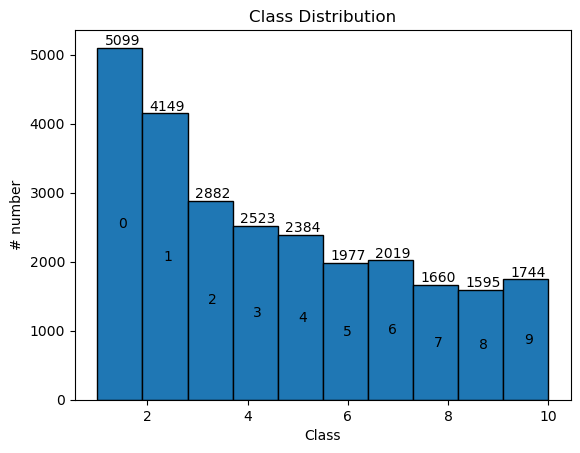

In [66]:
visualize_class_distr(test_labels)

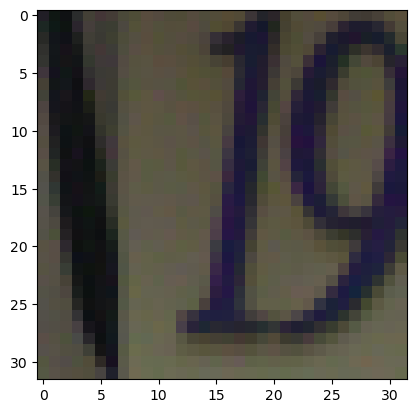

In [5]:
# show the first image
plt.imshow(train_images[0,:,:,:])
plt.show()

# 2 Feature Extraction

## 2.1 make a randomized search for the HP

### raw feature vectors

In [6]:
# 1. raw vectors. Concat pixels to one big vector. Very trivial
features1 = train_images.reshape(train_images.shape[0], -1)

In [7]:
features1.shape

(73257, 3072)

### grey scale images

In [8]:
# Display the original image and LBP image
def plot_images(images, feature_images, idx = 0):
    plt.figure(figsize=(12, 4))
    plt.subplot(121)
    plt.imshow(images[idx])
    plt.title("Original Image")

    plt.subplot(122)
    plt.imshow(feature_images[idx], cmap='gray')
    plt.title("Generated Image")

    plt.show()

In [5]:
# Preallocate the lbp_images array
def gray_scale(images):
    feature_images = np.empty((images.shape[0], images.shape[1], images.shape[2], 1), dtype=np.float32)

    # create the lpb images
    for i, image in enumerate(tqdm(images)):

        # Convert the image to grayscale (Harris corner detection works on grayscale images)
        gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

        feature_images[i, :, :, 0] = gray_image

    return feature_images


In [6]:
gray_images_train = gray_scale(train_images)
gray_images_test = gray_scale(test_images)

100%|██████████| 26032/26032 [00:00<00:00, 137737.09it/s]


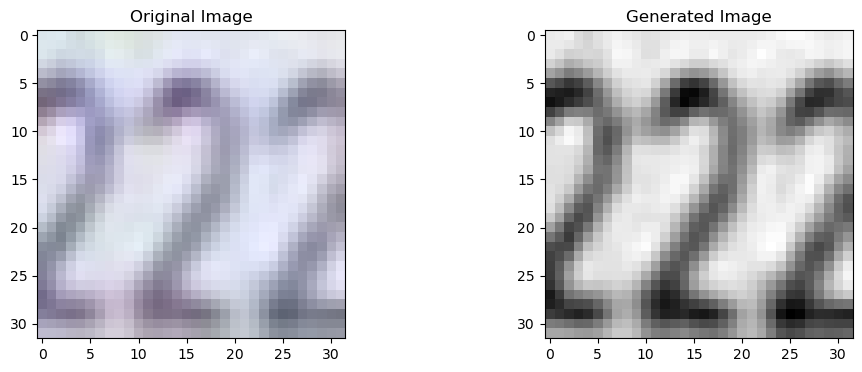

In [11]:
plot_images(train_images, gray_images_train, idx = 39)

### Local Binary Pattern

In [587]:
def lbp(images):

    # Preallocate the lbp_images array
    feature_images = np.empty((images.shape[0], images.shape[1], images.shape[2], 1), dtype=np.float32)

    # create the lpb images
    for i, image in enumerate(tqdm(images)):

        # Convert the image to grayscale (Harris corner detection works on grayscale images)
        gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

        # Compute LBP features
        radius = 3
        n_points = 8 * radius
        feature_images[i, :, :, 0] = feature.local_binary_pattern(gray_image, n_points, radius, method='uniform')

    return feature_images

In [585]:
lbp_images_train = lbp(train_images)
lbp_images_test = lbp(test_images)

100%|██████████| 26032/26032 [00:03<00:00, 8553.58it/s]


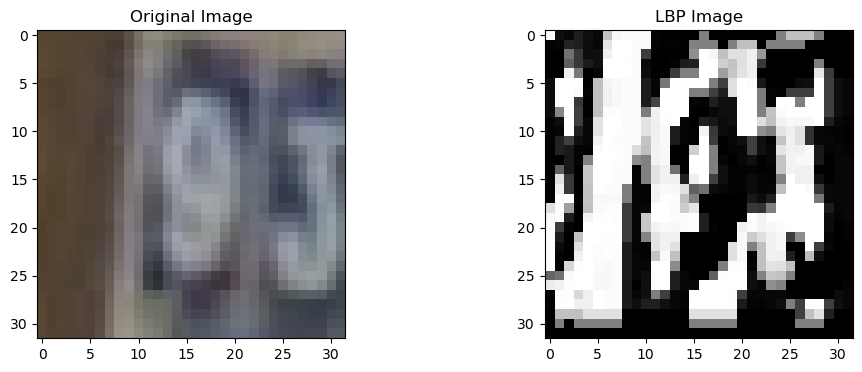

In [586]:
plot_images(train_images, lbp_images_train, idx = 6)

Difficulties:
what hyperparameters to choose?
sometimes the number is bright and sometimes the number is dark

### Harris Corner Detection

In [42]:
def hcd(images):

    # Preallocate the feature_images array
    feature_images = np.empty((images.shape[0], images.shape[1], images.shape[2], 1), dtype=np.float32)

    # Perform Harris Corner Detection

    for i, image in enumerate(tqdm(images)):

        # Convert the image to grayscale (Harris corner detection works on grayscale images)
        gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

        # Compute LBP features
        feature_images[i, :, :, 0] = cv2.cornerHarris(gray_image, blockSize=1, ksize=3, k=0.04)

    return feature_images

    # Threshold for corner detection
    #corner_threshold = 0.01 * corner_image.max()

In [43]:
hcd_images_train = hcd(train_images)
hcd_images_test = hcd(test_images)

100%|██████████| 26032/26032 [00:00<00:00, 38115.59it/s]


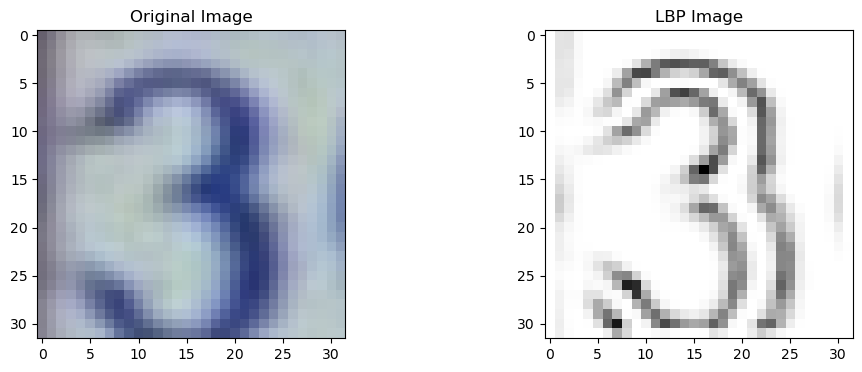

In [44]:
plot_images(train_images, hcd_images_train, idx = 1190)

problems: the filling is not white

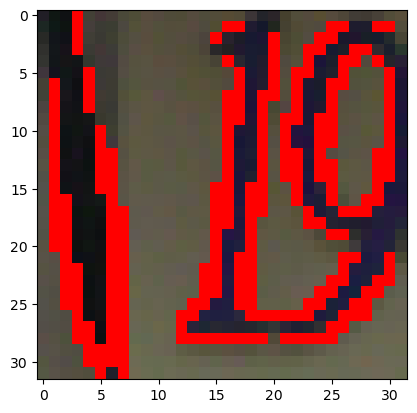

In [537]:
corner_image = hcd_images_train[0,:,:,0]
image = train_images[0,:,:,:]

# Threshold for corner detection
corner_threshold = 0.05 * corner_image.min()

# Create a copy of the original image
result_image = image.copy()

# Draw the detected corners on the result image
result_image[corner_image < corner_threshold] = [255, 0, 0]  # Set corners to red (BGR color format)

# Display the result
plt.imshow(result_image)

morgen: 2 weitere feature extraction methods
grid search implementieren für die hyperparameter
comparison based on cosine similarity

- was ich brauche ist das cropping auf die relevante zahl. --> alles andere im Bild sollte hintergrund sein
- combine local binary pattern matching and harris corner prediction

## 2.2 Quantifying the distinctivness of the features using silhoutte coefficient

In [12]:
X_train = gray_images_train.reshape(gray_images_train.shape[0], -1)
y_train = train_labels.ravel()
X_test = gray_images_test.reshape(gray_images_test.shape[0], -1)
y_test = test_labels.ravel()

In [465]:
# compare based on cosine similarity -> how similar are the feature vectors?

# for each class calculate the average cosine similarity score. the lower the better

array([1], dtype=uint8)

In [29]:
# process it in batches
def cosine_sim(data1, data2):

    # Calculate the L2 norm (Euclidean norm) for each vector
    l2_norms1 = np.sqrt(np.sum(data1**2, axis=1))
    l2_norms2 = np.sqrt(np.sum(data2**2, axis=1))

    # Normalize the data to have unit-length vectors (L2 norm = 1)
    normalized_data1 = data1 / l2_norms1[:, np.newaxis]
    normalized_data2 = data2 / l2_norms2[:, np.newaxis]

    # Calculate the cosine similarity matrix
    cosine_sim = np.dot(normalized_data1, normalized_data2.T)

    return cosine_sim

In [44]:
data1 = X_train[y_train==1]
data2 = X_train[y_train==1]

In [45]:
c = cosine_sim(data1, data2)

In [46]:
c.mean()

0.9121856

In [18]:
def calculate_distances_in_batches(X, batch_size):
    n = X.shape[0]
    distance_matrix = np.zeros((n, n))  # Initialize the distance matrix

    for i in tqdm(range(0, n, batch_size)):
        end = min(i + batch_size, n)
        batch = X[i:end]  # Take a batch of data points
        batch_distances = pairwise_distances(batch, X)  # Calculate distances for the batch
        distance_matrix[i:end] = batch_distances  # Update the distance matrix with the batch

    return distance_matrix

In [16]:
# silhouette coefficient is a measure of how similar an object is to its own cluster (cohesion) compared to other clusters (separation)
def silhouette_coefficient(X, labels):
    # Calculate pairwise distances between data points
    batch_size = 1000  # Adjust this to your needs
    distance_matrix = calculate_distances_in_batches(X, batch_size)

    n = len(X)
    silhouette_values = []

    for i in tqdm(range(n)):
        # average distance from the data point i to the other data points in the same cluster.
        a = np.mean(distance_matrix[i][labels == labels[i]])
        # minimum average distance from the data point i to the data points in a different cluster, minimizing over clusters.
        b = min([np.mean(distance_matrix[i][labels != label]) for label in set(labels) if label != labels[i]])
        s = (b - a) / max(a, b)
        silhouette_values.append(s)

    return np.mean(silhouette_values)

In [12]:
def silhouette_coefficient(X, labels):

    tqdm.pandas()

    distance_matrix = pairwise_distances(X)
    n = len(X)

    # Define a lambda function to calculate the silhouette value for a single data point
    calculate_silhouette = lambda i: (lambda a, b: (b - a) / max(a, b))(
        np.mean(distance_matrix[i][labels == labels[i]]),
        min([np.mean(distance_matrix[i][labels != label]) for label in set(labels) if label != labels[i]])
    )

    silhouette_values = pd.Series(range(n)).progress_apply(calculate_silhouette)

    return silhouette_values.mean()

In [ ]:
# Compute the silhouette coefficient for your data and labels
silhouette = silhouette_coefficient(X_train, y_train)
print("Silhouette Coefficient:", silhouette)

 57%|█████▋    | 42/74 [01:21<01:16,  2.39s/it]

### 2.3 Investigate classes with low intra-class similarities and high inter-class similarities

In [ ]:
# get silhouette coefficient mean for separate classes. Thats how it can be detected

In [ ]:
# visualize it using two bar plots. one for intra class similarity and one for inter class similarity

# 3. Classification

## 3.1 Use K-nearest Neighbor for classification

In [13]:
gray_images_train.shape

(73257, 32, 32, 1)

In [72]:
X_train = gray_images_train.reshape(gray_images_train.shape[0], -1)
y_train = train_labels.ravel()
X_test = gray_images_test.reshape(gray_images_test.shape[0], -1)
y_test = test_labels.ravel()

In [16]:
X_test.shape

(26032, 1024)

In [41]:
# Create a k-NN classifier
knn = KNeighborsClassifier(n_neighbors=400, n_jobs=-1)

# Fit the classifier to the training data
knn.fit(X_train, y_train)

# Make predictions on the train data
y_pred_train = knn.predict(X_train)

# Make predictions on the test data
y_pred_test = knn.predict(X_test)

In [42]:
acc_train = metrics.accuracy_score(y_train, y_pred_train)
acc_test = metrics.accuracy_score(y_test, y_pred_test)

print(f'Accuracy on train set: {acc_train}')
print(f'Accuracy on test set {acc_test}')

Accuracy on train set: 0.4368729268192801
Accuracy on test set 0.44038106945298094


In [ ]:
# challenge: how to determine the best hyperparameter?
# answer: get another set of data from the training set for validation and perform a grid search to find the best number of k and train the classifier on the entire training data afterwards with the best found HPs.

In [73]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, random_state=42, shuffle=True, stratify=y_train, train_size=0.8)

In [ ]:
# check performance over different k's
# list_k = [3,5,8,10,12,15,20,30,40,50,60,80,100]

list_k = [3,5,10,20,40,60,80,100,150,200,300,400,500]


result_df = pd.DataFrame(columns=['acc_train', 'acc_valid'], index=list_k)

for k in list_k:
    # Create a k-NN classifier
    knn = KNeighborsClassifier(n_neighbors=k, n_jobs=-1)

    # Fit the classifier to the training data
    knn.fit(X_train, y_train)

    # Make predictions on the train data
    y_pred_train = knn.predict(X_train)

    # Make predictions on the validation data
    y_pred_valid = knn.predict(X_valid)

    acc_train = metrics.accuracy_score(y_train, y_pred_train)
    acc_valid = metrics.accuracy_score(y_valid, y_pred_valid)

    # Store results
    result_df.loc[k,:] = [acc_train, acc_valid]

    # print results
    print(f'k is {k}')
    print(f'Accuracy on train set: {acc_train}')
    print(f'Accuracy on valid set {acc_valid}')
    print('-'*50)
    print()

In [18]:
result_df[::-1]

,acc_train,acc_test
50,0.564165,0.521281
45,0.569038,0.521243
40,0.576191,0.523932
35,0.582675,0.524163
30,0.590415,0.52278
25,0.600379,0.522703
20,0.610167,0.524662
15,0.624855,0.525853
12,0.635939,0.523586
10,0.644403,0.520283


In [35]:
sorted_df = (1-result_df).iloc[2:][::-1].copy()

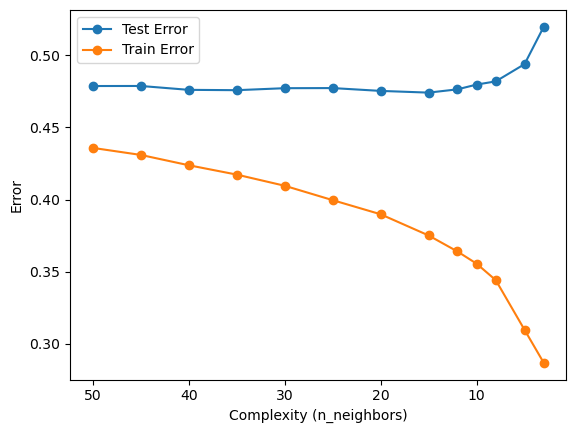

In [40]:
fig, ax1 = plt.subplots(1, 1)

# Plot 'acc_test' and 'acc_train' with labels
ax1.plot(sorted_df.index, sorted_df['acc_test'], marker="o", label='Test Error')
ax1.plot(sorted_df.index, sorted_df['acc_train'], marker="o", label='Train Error')

# Invert the x-axis
ax1.invert_xaxis()

# Add a legend
ax1.legend()

# Add x-axis and y-axis labels
ax1.set_xlabel('Complexity (n_neighbors)')
ax1.set_ylabel('Error')

# Show the plot
plt.show()

<Axes: >

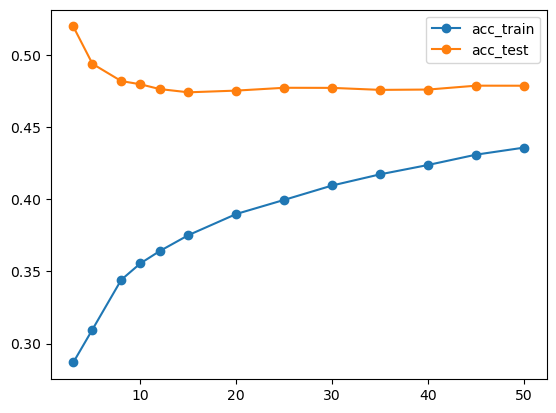

In [20]:
(1-result_df).iloc[2:].plot(marker="o")

## 3.2 Use a linear discriminant function for classification

## 3.3 Do you observe any overfitting/underfitting?

In [ ]:
# we should tune the hyperparameter to find the optimal values for the best performance. I already implemented a grid search over different values of k and therefore were able to select the best hyperparameter given the features I extracted
